# Лабораторная работа №2. Системы линейных алгебраических уравнений

Цель работы: решить СЛАУ следующими способами:
- метод Гаусса с выбором главного элемента
- метод LU-разложения (если применим)
- метод Якоби
- метод Зейделя
- метод верхней релаксации
- метод градиентного спуска
- метод минимальных невязок
- стабилизированный метод бисопряженных градиентов

Для итерационных методов получить график убывания невязки в зависимости от итерации

Импортируем библиотеки:

In [1]:
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

Выбранная СЛАУ \--- вариант р) из номера II.10.5. (практикум Аристова, Лобанова, Завьялова)
![SOLE](var.jpeg)

Выпишем необходимую матрицу

In [47]:
n = 49 

def initialMatrix():
    a_i = lambda i: 1
    b_i = lambda i: 5
    c_i = lambda i: 1
    p_i = lambda i: 1 

    matA = np.zeros((n + 1, n + 1))

    for idx in range(0, n):
        matA[idx, idx] = b_i(idx)

    for idx in range(0, n - 1):
        matA[idx + 1, idx] = a_i(idx)

    for idx in range(0, n):
        matA[idx, idx + 1] = c_i(idx)

    for idx in range(0, n + 1):
        matA[n, idx] = p_i(idx)
    
    return matA

n = 100

def initialMatrix():
    a    = lambda i: 10
    b_ij = lambda i: 1/i
    f_i  = lambda i: i

    matxA = np.zeros((n, n))
    matxF = np.arange(1, n+1)

    def fill_matxA(mx):
        num_rows, num_cols = mx.shape
        for row in range(num_rows):
            for col in range(num_cols):
                if row > col:
                    mx[row][col] = b_ij(row+1)
                elif row == col:
                    mx[row][col] = a(row+1)
                elif row + 1 == col and row + 1 < n:
                    mx[row][col] = b_ij(row+1)
    
    fill_matxA(matxA)

    return matxA

def initialFreevec():
    f_i = lambda i: i+1
    
    vecF = np.empty([n])
    for idx in range(0, n):
        vecF[idx] = f_i(idx)

    return vecF


def dumpMatrix(matrix):
    display(pd.DataFrame(matrix))

dumpMatrix(initialMatrix())


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.500000,10.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.333333,0.333333,10.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.250000,0.250000,0.250000,10.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.200000,0.200000,0.200000,0.200000,10.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,0.010417,...,0.010417,0.010417,0.010417,0.010417,0.010417,10.000000,0.010417,0.000000,0.000000,0.000000
96,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,...,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,10.000000,0.010309,0.000000,0.000000
97,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,...,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,10.000000,0.010204,0.000000
98,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,10.000000,0.010101


In [48]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

def mat_norm(matrix):
    return np.linalg.norm(matrix, ord=np.inf)


# Метод Гаусса

In [49]:
def swapCols(matrix, first, second):
    matrix[:, [first, second]] = matrix[:, [second, first]]

def swapRows(matrix, first, second):
    matrix[[first, second]] = matrix[[second, first]]

def soleGauss(matrix, free):
    matrix = matrix.copy()
    free = free.copy()
    dim = matrix.shape[0]

    # Positions of variables
    vars = np.arange(dim)

    # Direct pass with choosing max leader
    for cur in range(0, dim - 1):
        # Find max value in submatrix
        submatrix = matrix[cur:, cur:]
        max_y, max_x = np.unravel_index(np.argmax(submatrix), submatrix.shape)
        max_y += cur
        max_x += cur

        # Swap with leader
        swapRows(matrix, cur, max_y)
        swapCols(matrix, cur, max_x)
        vars[[cur, max_x]] = vars[[max_x, cur]]
        free[[cur, max_y]] = free[[max_y, cur]]

        # Subtract current row from remaining rows
        for idx in range(cur + 1, dim):
            factor = matrix[idx, cur] / matrix[cur, cur]
            matrix[idx] -= factor * matrix[cur]
            free[idx]   -= factor * free[cur]

    roots = np.zeros(dim)
    for cur in reversed(range(0, dim)):
        tmp = free[cur]
        for idx in range(cur + 1, dim):
            tmp -= matrix[cur, idx] * roots[idx]

        roots[cur] = tmp / matrix[cur][cur]

    # Restore variable order
    roots = roots[vars]
    return roots

In [50]:
A = initialMatrix()
f = initialFreevec()

roots = soleGauss(A, f)
ref_roots = np.linalg.solve(A, f)

print(norm(roots - ref_roots))
print(norm(np.matmul(A, roots) - f))


9.250320294617271
92.41069974322654


# LU-разложение

In [51]:
def getLU(matrix):
    dim = matrix.shape[0]
    U = matrix.copy()
    L = np.identity(dim)

    for leader in range(0, dim):
        for idx in range(leader + 1, dim):
            L[idx, leader] = U[idx, leader] / U[leader, leader]
            U[idx] -= L[idx, leader] * U[leader]

    return L, U

def soleLU(matrix, free):
    dim = matrix.shape[0]

    L, U = getLU(matrix)

    # Ly = free
    y = np.zeros(dim)
    for cur in range(0, dim):
        tmp = free[cur]
        for idx in range(0, cur):
            tmp -= L[cur, idx] * y[idx]
        y[cur] = tmp / L[cur, cur]
    
    # Ux = y
    x = np.zeros(dim)
    for cur in reversed(range(0, dim)):
        tmp = y[cur]
        for idx in range(cur + 1, dim):
            tmp -= U[cur, idx] * x[idx]
        x[cur] = tmp / U[cur][cur]

    return x

In [52]:
A = initialMatrix()
f = initialFreevec()

L, U = getLU(A)
L_ref, U_ref = sp.linalg.lu(A, permute_l=True)
print("LU разложение:")
print(mat_norm(L - L_ref))
print(mat_norm(U - U_ref))

ref_roots = np.linalg.solve(A, f)
roots = soleLU(A, f)

print("Корни:")
print(norm(roots - ref_roots))
print(norm(np.matmul(A, roots) - f))
print(norm(np.matmul(A, ref_roots) - f))

LU разложение:
6.938893903907228e-18
5.579177884952902e-17
Корни:
0.0
1.1368683772161603e-13
1.1368683772161603e-13


# Итерационные методы

In [53]:
def soleFpi(n_iter, B, F, matrix, free):
    dim = matrix.shape[0]
    u = np.zeros(dim)

    diff = []
    for it in range(0, n_iter):
        u = np.matmul(B, u) + F
        diff.append(norm(np.matmul(matrix, u) - free))
    
    return u, diff

def getLDU(matrix):
    dim = matrix.shape[0]

    inds = np.tril_indices(dim, k=-1) 
    L = np.zeros(matrix.shape)
    L[inds] = matrix[inds]

    inds = np.triu_indices(dim, k=1)
    U = np.zeros(matrix.shape)
    U[inds] = matrix[inds]

    inds = np.diag_indices(dim)
    D = np.zeros(matrix.shape)
    D[inds] = matrix[inds]

    return L, D, U

In [54]:
def soleZeydel(n_iter, matrix, free):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(L + D), U)
    F = np.matmul(np.linalg.inv(L + D), free)

    return soleFpi(n_iter, B, F, matrix, free)

def soleJacobi(n_iter, matrix, free):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(D), L + U)
    F = np.matmul(np.linalg.inv(D), free)

    return soleFpi(n_iter, B, F, matrix, free)

def soleSOR(n_iter, matrix, free, tau):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(D + tau * L), (tau - 1) * D + tau * U)
    F = tau * np.matmul(np.linalg.inv(D + tau * L), free)

    return soleFpi(n_iter, B, F, matrix, free)



Сравнение (Зейдель):
1.4210854715202004e-14
2.842170943040401e-14
1.1368683772161603e-13
Сравнение (Якоби):
1.4210854715202004e-14
2.842170943040401e-14
1.1368683772161603e-13
Сравнение (МВР):
1.2434497875801753e-14
1.4210854715202004e-14
1.1368683772161603e-13


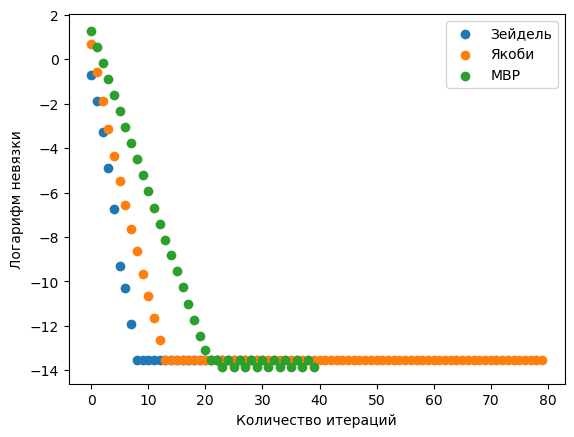

In [55]:
def test(method, n_iter, name):
    A = initialMatrix()
    f = initialFreevec()

    roots, diff = method(n_iter, A, f)
    ref_roots = np.linalg.solve(A, f)

    print(f"Сравнение ({name}):")
    print(norm(roots - ref_roots))
    print(norm(np.matmul(A, roots) - f))
    print(norm(np.matmul(A, ref_roots) - f))

    plt.scatter(range(0, len(diff)), np.log10(diff), label=name)

test(soleZeydel, 30, "Зейдель")
test(soleJacobi, 80, "Якоби")
test(lambda n_iter, matrix, free: soleSOR(n_iter, matrix, free, 1.2), 40, "МВР")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()

# Вариационные методы

Для последующих методов надо работать с симметричной матрицей:

In [56]:
def soleFpi(n_iter, tau, matrix, free):
    dim = matrix.shape[0]
    u = np.ones(dim)

    diff = []
    
    for it in range(0, n_iter):
        res =  free - np.matmul(matrix, u)
        u = u + tau(matrix, res) * res
        
        diff.append(norm(res))
    
    return u, diff

In [57]:
def grad_desc(matrix, res):
    A_r = np.matmul(matrix, res)
    return np.matmul(res, res) / np.matmul(A_r, res)
    return

def min_res(matrix, res):
    A_r = np.matmul(matrix, res)
    return np.matmul(A_r, res) / np.matmul(A_r, A_r)

Сравнение (Градиентный спуск):
1.5987211554602254e-14
1.1368683772161603e-13
1.7053025658242404e-12
Сравнение (Минимальная невязка):
1.5987211554602254e-14
1.1368683772161603e-13
1.7053025658242404e-12


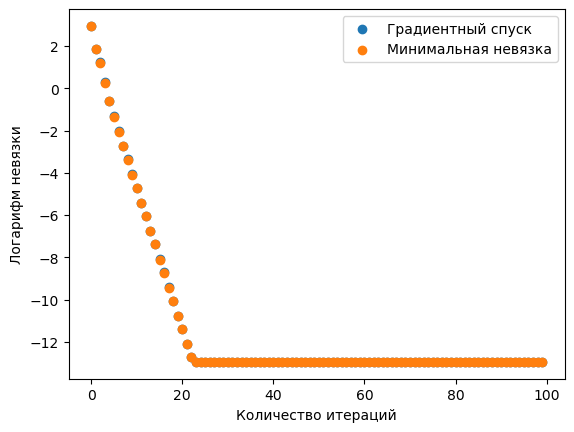

In [59]:
def test(method, n_iter, name):
    A = initialMatrix()
    A_transpose = np.transpose(A)
    A = np.matmul(A_transpose, A)
    f = np.matmul(A_transpose, initialFreevec())

    values, vectors = np.linalg.eig(A)

    roots, diff = soleFpi(n_iter, method, A, f)
    ref_roots = np.linalg.solve(A, f)

    print(f"Сравнение ({name}):")
    print(norm(roots - ref_roots))
    print(norm(np.matmul(A, roots) - f))
    print(norm(np.matmul(A, ref_roots) - f))

    plt.scatter(range(0, len(diff)), np.log10(diff), label=name)

test(grad_desc, 100, "Градиентный спуск")
test(min_res, 100, "Минимальная невязка")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()